In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [2]:
# Set paths for your dataset
train_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
val_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Validation'
test_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Testing'

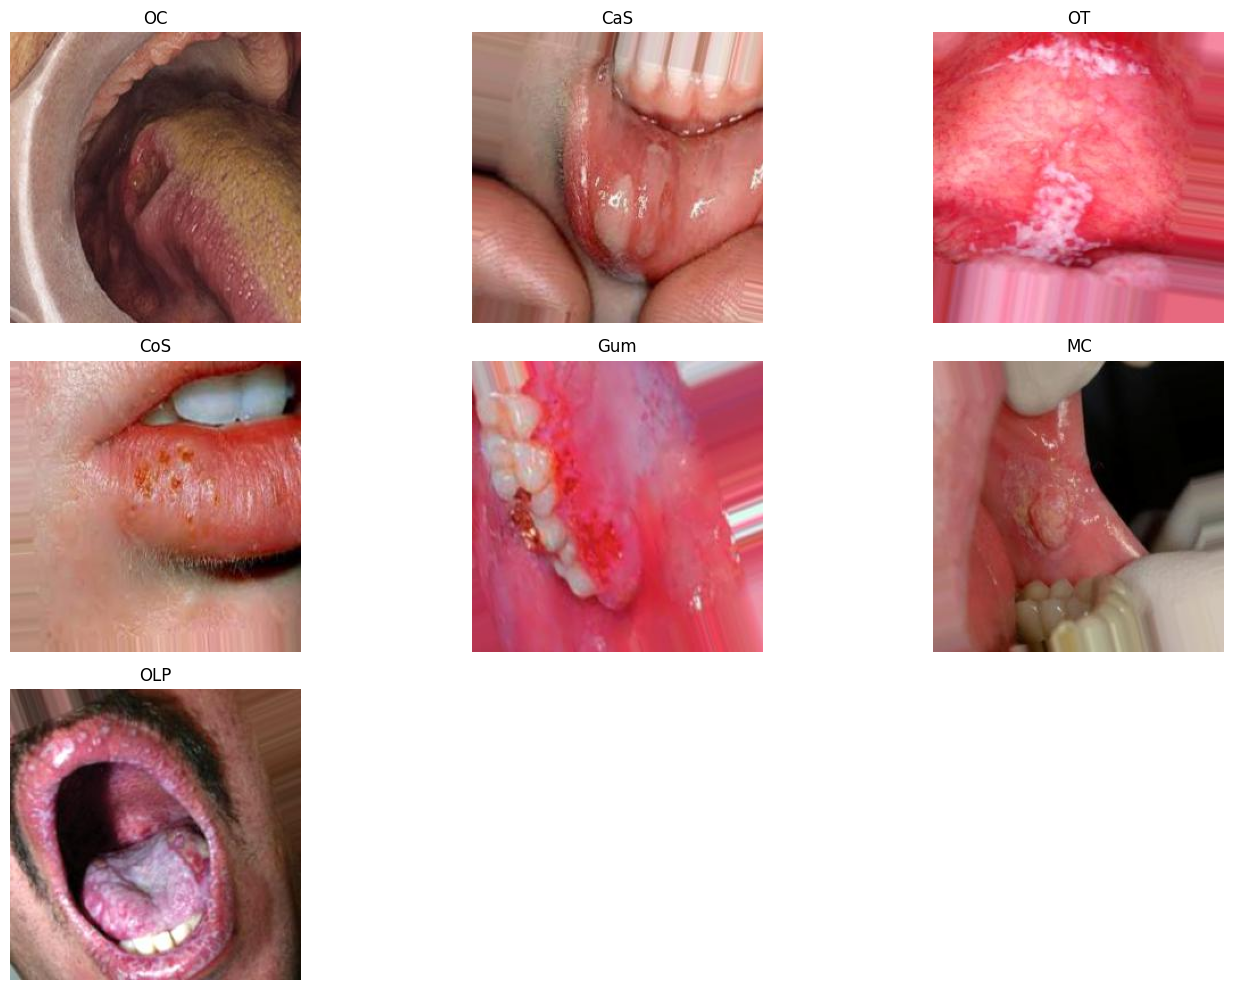

In [3]:
from PIL import Image
import os
import matplotlib.pyplot as plt
# List of classes (subfolders)
classes = os.listdir(train_dir)  # Use the actual directory path here

# Function to plot sample images from each class
def plot_sample_images(train_dir, classes):
    plt.figure(figsize=(14, 10))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(train_dir, class_name)
        sample_image = os.listdir(class_path)[0]  # Get first image
        image_path = os.path.join(class_path, sample_image)
        img = Image.open(image_path)

        # Plot the image
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images(train_dir, classes)  # Pass the directory path

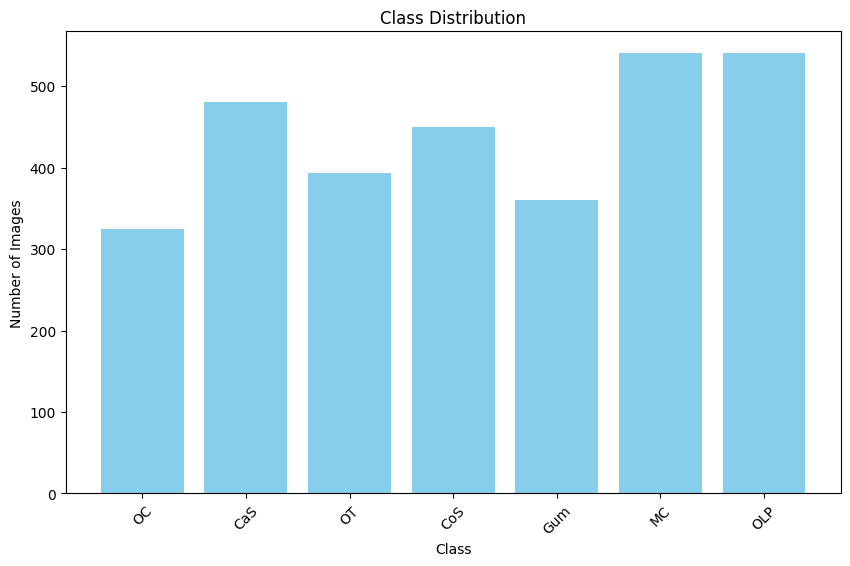

{'OC': 324, 'CaS': 480, 'OT': 393, 'CoS': 450, 'Gum': 360, 'MC': 540, 'OLP': 540}


In [4]:
# Function to count images in each class
def count_images_in_classes(train_dir, classes):
    class_distribution = {}
    for class_name in classes:
        class_path = os.path.join(train_dir, class_name)
        # Count the number of files (images) in the class folder
        num_images = len(os.listdir(class_path))
        class_distribution[class_name] = num_images
    return class_distribution

# Get the class distribution
class_distribution = count_images_in_classes(train_dir, classes)

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

# Print the class distribution
print(class_distribution)

In [5]:
# Load the dataset
batch_size = 32
img_size = (224, 224)  # ResNet expects 224x224 input size

In [6]:

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)
class_names = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_names=class_names
)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from keras.applications import MobileNetV2

# Initialize base model
IMG_SHAPE = (224, 224, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = True

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMG_SHAPE),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # This reduces the 4D output to 2D
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax', kernel_regularizer=l2(0.01))
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 mode='max',
                                                 min_delta=0.01,
                                                 patience=3,
                                                 factor=0.25,
                                                 verbose=1,
                                                 cooldown=0,
                                                 min_lr=1e-8)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 mode='max',
                                                 min_delta=0.005,
                                                 patience=10,
                                                 verbose=1,
                                                 restore_best_weights=True)

# Preprocessing function
def preprocess(image, label):
    label = tf.one_hot(label, depth=7)  # Convert label to one-hot encoding
    return image, label

# Apply the preprocessing
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Fit the model
history = model.fit(train_dataset, 
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=[early_stopper, reduce_lr])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/25


I0000 00:00:1724979916.164122     112 service.cc:145] XLA service 0x7e90cc0031e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724979916.164173     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/97 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.1953 - loss: 8.4373    

I0000 00:00:1724979938.444199     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.2734 - loss: 7.9531

I0000 00:00:1724979964.928170     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_45', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_44', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_49', 8 bytes spill stores, 8 bytes spill loads



97/97 ━━━━━━━━━━━━━━━━━━━━ 72s 350ms/step - accuracy: 0.2745 - loss: 7.9499 - val_accuracy: 0.2072 - val_loss: 8.3488 - learning_rate: 0.0010
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.6534 - loss: 6.8416 - val_accuracy: 0.2305 - val_loss: 8.7009 - learning_rate: 0.0010
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.8387 - loss: 6.1329 - val_accuracy: 0.2568 - val_loss: 8.8272 - learning_rate: 0.0010
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9394 - loss: 5.6553 - val_accuracy: 0.3405 - val_loss: 8.0209 - learning_rate: 0.0010
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9734 - loss: 5.3463 - val_accuracy: 0.3512 - val_loss: 7.7111 - learning_rate: 0.0010
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9849 - loss: 5.1095 - val_accuracy: 0.4650 - val_loss: 6.8231 - learning_rate: 0.0010
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9910 - loss: 4.9017 - val_accuracy: 0.

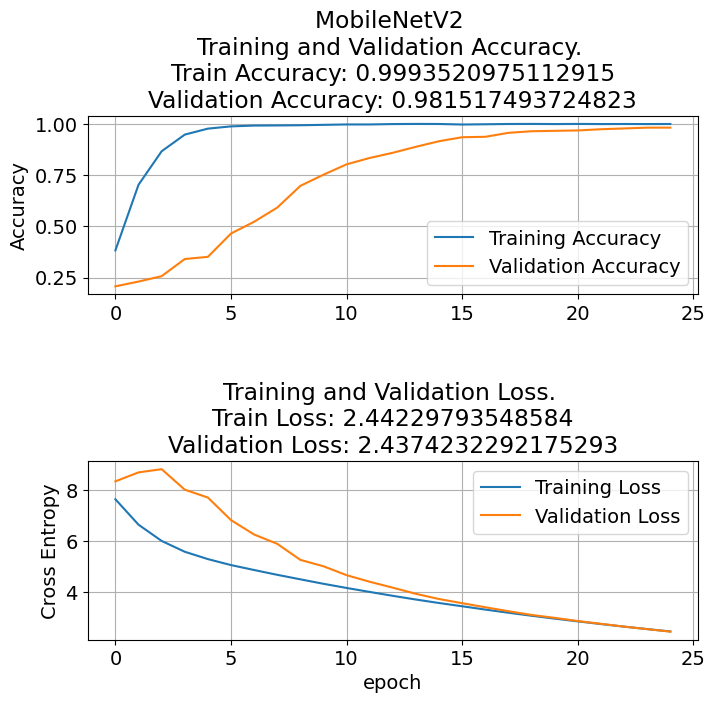

In [8]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [24]:
# Save the weights
model.save_weights('/kaggle/working/o.weights.h5')

In [23]:
# Recreate the model architecture
IMG_SHAPE = (224, 224, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = True

# Define the model (same architecture as before)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMG_SHAPE),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax', kernel_regularizer=l2(0.01))
])

# Load the saved weights
model.load_weights('.weights.h5')
# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

# Evaluate the model (for example, on validation data)
loss, accuracy = model.evaluate(val_dataset)
print(f"Model accuracy after loading weights: {accuracy:.2f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9838 - loss: 2.5868
Model accuracy after loading weights: 0.98


In [36]:
import tensorflow as tf
import numpy as np
from PIL import Image

def load_and_preprocess_image(image_path):
    # Load the image using PIL
    img = Image.open(image_path)
    
    # Resize the image to the input shape of the model
    img = img.resize((224, 224))
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Add a batch dimension to the image array
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def predict_image(image_path):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    
    # Make predictions using the model
    predictions = model.predict(img_array)
    print(predictions)
    # Get the predicted class index
    predicted_index = np.argmax(predictions, axis=1)[0]
    
    # Convert the predicted class index to a one-hot encoded vector
    predicted_label = np.zeros(7)  # Assuming there are 7 classes
    predicted_label[predicted_index] = 1
    
    return predicted_label

# Test the model on an external image
image_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Testing/OT/ot_1200_0_8369.jpg'
predicted_label = predict_image(image_path)
print(f'Predicted one-hot encoded label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[9.5479103e-05 2.4460722e-04 4.7218238e-04 1.5215161e-04 1.1831608e-03
  2.1270914e-03 9.9572539e-01]]
Predicted one-hot encoded label: [0. 0. 0. 0. 0. 0. 1.]


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Accuracy: 99.22%


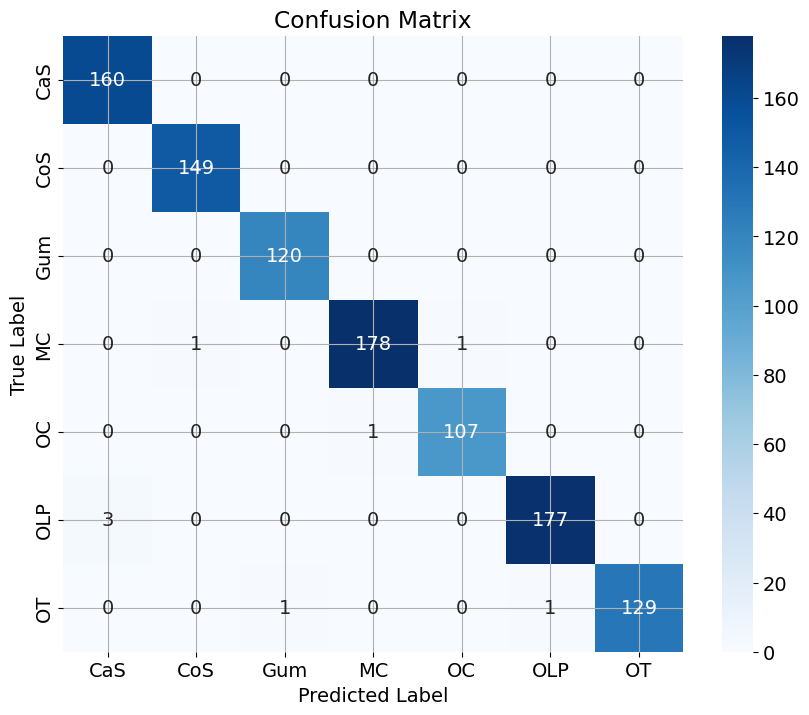

              precision    recall  f1-score   support

         CaS       0.98      1.00      0.99       160
         CoS       0.99      1.00      1.00       149
         Gum       0.99      1.00      1.00       120
          MC       0.99      0.99      0.99       180
          OC       0.99      0.99      0.99       108
         OLP       0.99      0.98      0.99       180
          OT       1.00      0.98      0.99       131

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028



In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Convert one-hot encoded y_true to integer labels
y_true_int = np.argmax(y_true, axis=1)

# Get the predicted labels
predictions = model.predict(test_dataset)
y_pred_int = np.argmax(predictions, axis=1)

# Convert integer predictions back to one-hot encoding for comparison
y_pred = []
for i in range(len(y_pred_int)):
    x = [0, 0, 0, 0, 0, 0, 0]
    x[y_pred_int[i]] = 1
    y_pred.append(x)
y_pred = np.array(y_pred)

# Loop over y_pred and y_true to check for matches and calculate accuracy
correct_predictions = 0
for i in range(len(y_true)):
    if np.array_equal(y_true[i], y_pred[i]):
        correct_predictions += 1

accuracy = correct_predictions / len(y_true)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Create a confusion matrix using integer labels
cm = confusion_matrix(y_true_int, y_pred_int)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true_int, y_pred_int, target_names=class_names))
